# Global Settings

In [ ]:
#@title GLOBAL IMPORTS

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
import os
import imutils
import random
import time
import shutil
from google.colab import drive
# from operator import itemgetter
# from glob import glob

In [ ]:
#@title GLOBAL PARAMS

PARAMS = {
    'GLOBAL': {
        'aruco_folder': 'aruco'
    },
    'ARUCO_GEN': { # Aruco Generation Params
        'out_dir_name': 'original_aruco',
        'nr_of_aruco': 15,
        'type_of_aruco': 'DICT_4X4_1000',
        'aruco_width': 30,
        'aruco_height': 30,
        'aruco_border_size': 5 # ATT!! total dims: width=aruco_width + (2 * aruco_border_size), height=...
    },
    'ARUCO_TRANSF': { # Perspective Transformation Params
        'aruco_filename': 'aruco/aruco_13.jpg',
        'out_dir_name': 'edited_aruco',
        'nr_of_transformations': 5,
        'reduct_fact_width': 1/2,
        'reduct_fact_height': 2/7, #3/14
        'range_brightness_alpha': [1, 1] , # gain
        'range_brightness_beta': [-40, 100], # bias
    },
    'COCO_DATASET': { # COCO Dataset Params
        'imgs_dir_name': 'coco/images',
        # 'ann_dir_name': 'coco/annotations'
    },
    'IMAGE_OVERLAY': { # Image Overlay Params
        'aruco_filename': 'aruco/aruco_13.jpg',
        'image_filename': 'coco/images/train2017/000000147328.jpg',
        'dataset_path': 'dataset',
        'labels_path': 'labels',
        'imgs_path': 'images',
        'canny_threshold1': 10,
        'canny_threshold2': 100,
        'nr_of_imgs_for_aruco': 20,
        'range_images_size_width': [500, 700],
        'range_images_size_height': [500, 700]
    }
}

# ArUco Generation in OpenCV

In [ ]:
#@title ArUco Generation PARAMETERS
name_of_directory = os.path.join(PARAMS['GLOBAL']['aruco_folder'], PARAMS['ARUCO_GEN']['out_dir_name'])
nr_of_aruco = PARAMS['ARUCO_GEN']['nr_of_aruco']
type_of_aruco = PARAMS['ARUCO_GEN']['type_of_aruco']
aruco_width = PARAMS['ARUCO_GEN']['aruco_width'] # in number of pixels
aruco_height = PARAMS['ARUCO_GEN']['aruco_height'] # in number of pixels
bordersize = PARAMS['ARUCO_GEN']['aruco_border_size'] # in number of pixels

## Code

In [ ]:
# define names of each possible ArUco tag OpenCV supports
ARUCO_DICT = {
	"DICT_4X4_50": cv2.aruco.DICT_4X4_50,
	"DICT_4X4_100": cv2.aruco.DICT_4X4_100,
	"DICT_4X4_250": cv2.aruco.DICT_4X4_250,
	"DICT_4X4_1000": cv2.aruco.DICT_4X4_1000,
	"DICT_5X5_50": cv2.aruco.DICT_5X5_50,
	"DICT_5X5_100": cv2.aruco.DICT_5X5_100,
	"DICT_5X5_250": cv2.aruco.DICT_5X5_250,
	"DICT_5X5_1000": cv2.aruco.DICT_5X5_1000,
	"DICT_6X6_50": cv2.aruco.DICT_6X6_50,
	"DICT_6X6_100": cv2.aruco.DICT_6X6_100,
	"DICT_6X6_250": cv2.aruco.DICT_6X6_250,
	"DICT_6X6_1000": cv2.aruco.DICT_6X6_1000,
	"DICT_7X7_50": cv2.aruco.DICT_7X7_50,
	"DICT_7X7_100": cv2.aruco.DICT_7X7_100,
	"DICT_7X7_250": cv2.aruco.DICT_7X7_250,
	"DICT_7X7_1000": cv2.aruco.DICT_7X7_1000,
	"DICT_ARUCO_ORIGINAL": cv2.aruco.DICT_ARUCO_ORIGINAL,
	"DICT_APRILTAG_16h5": cv2.aruco.DICT_APRILTAG_16h5,
	"DICT_APRILTAG_25h9": cv2.aruco.DICT_APRILTAG_25h9,
	"DICT_APRILTAG_36h10": cv2.aruco.DICT_APRILTAG_36h10,
	"DICT_APRILTAG_36h11": cv2.aruco.DICT_APRILTAG_36h11
}

In [ ]:
!rm -R /content/aruco

rm: cannot remove '/content/aruco': No such file or directory


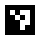

(40, 40)




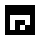

(40, 40)




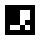

(40, 40)




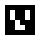

(40, 40)




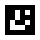

(40, 40)




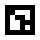

(40, 40)




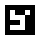

(40, 40)




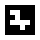

(40, 40)




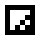

(40, 40)




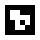

(40, 40)




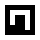

(40, 40)




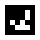

(40, 40)




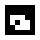

(40, 40)




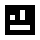

(40, 40)




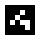

(40, 40)




In [ ]:
# create the output directory
Path(name_of_directory).mkdir(parents=True, exist_ok=True)

# load the ArUco dictionary
arucoDict = cv2.aruco.Dictionary_get(ARUCO_DICT[type_of_aruco])

for arucoID in range(nr_of_aruco):
  # allocate memory for the output ArUco tag
  tag = np.zeros((aruco_width, aruco_height, 1), dtype="uint8")
  # draw the ArUco tag on the output image
  cv2.aruco.drawMarker(arucoDict, arucoID, aruco_width, tag, 1)

  # add white border
  tag = cv2.copyMakeBorder(
    tag,
    top=bordersize,
    bottom=bordersize,
    left=bordersize,
    right=bordersize,
    borderType=cv2.BORDER_CONSTANT,
    value=[255, 255, 255]) 
  
  # write the generated ArUco tag to disk and then print it
  cv2.imwrite(os.path.join(name_of_directory, f'aruco_{arucoID:02d}.jpg'), tag)
  cv2_imshow(tag)
  print(tag.shape)
  print('\n')


# All ArUco Transformations

In [ ]:
#@title OpenCV Transformations PARAMETERS
out_dir = os.path.join(PARAMS['GLOBAL']['aruco_folder'], PARAMS['ARUCO_TRANSF']['out_dir_name'])
reduct_fact_width = PARAMS['ARUCO_TRANSF']['reduct_fact_width']
reduct_fact_height = PARAMS['ARUCO_TRANSF']['reduct_fact_height']
nr_of_transf = PARAMS['ARUCO_TRANSF']['nr_of_transformations']
range_brightness_alpha = PARAMS['ARUCO_TRANSF']['range_brightness_alpha']
range_brightness_beta = PARAMS['ARUCO_TRANSF']['range_brightness_beta']

In [ ]:
def perspective_transf(paper, reduct_fact_width, reduct_fact_height):
  # read the ArUco width and height
  paper_width, paper_height = paper.shape[:2]
  # print(paper.shape[:2])
  
  # set the size of the result image 
  # out_width, out_height = paper_width, paper_height #ALTERNATIVA
  out_width, out_height = paper_width + 10, paper_height + 10

  # set the coordinates that we want to perspective transform (the coords of the whole image)
  pts1 = np.float32([[0,0], [paper_width - 1 ,0], [paper_height - 1,paper_width - 1], [0, paper_height - 1]])

  # size of the transformed image
  new_width = round(paper_width * reduct_fact_width)
  new_height = round(paper_height * reduct_fact_height)

  # top left point
  # tl_point_x = 0 #ALTERNATIVA
  # tl_point_y = 0 #ALTERNATIVA
  tl_point_x = round((out_width - paper_width)/2)
  tl_point_y = round((out_height - paper_height)/2)
  tl_point = [tl_point_x, tl_point_y]
  # print(tl_point)

  # top right point
  tr_point_x = tl_point_x + (paper_width - 1)
  tr_point_y = tl_point_y
  tr_point = [tr_point_x, tr_point_y]
  # print(tr_point)

  # bottom left point
  bl_point_x = tl_point_x + (round((paper_width - new_width) / 2)) - 1
  bl_point_y = tl_point_y + (new_height - 1)
  bl_point = [bl_point_x, bl_point_y]
  # print(bl_point)

  # bottom right point
  br_point_x = bl_point_x + (new_width - 1)
  br_point_y = bl_point_y
  br_point = [br_point_x, br_point_y]
  # print(br_point)

  # edited_aruco = perspective_transf(original_aruco, np.float32([[10,20],[49,20],[39,35],[20,35]]))
  pts2 = np.float32([tl_point, tr_point, br_point, bl_point])
  # pts2 = np.float32([[4,4], [44,4], [34,13], [14,13]])
  # pts2 = np.float32([[0, 0], [39, 0],[15, 15],[35, 15]])


  # transformation matrix
  M = cv2.getPerspectiveTransform(pts1, pts2)
  # transform the original image
  return cv2.warpPerspective(paper, M, (out_width, out_height))


In [ ]:
!rm -R /content/aruco/edited_aruco/

In [ ]:
def make_transf(orig_aruco, aruco_name, nr_of_transf, index):

  if nr_of_transf == 0:
    return
  else:
    # rotation transformation
    rotation_angle = random.randrange(0, 360)
    edited_aruco = imutils.rotate_bound(orig_aruco, rotation_angle)
    # print transformed image
    plt.title(f'Rotation transformation with angle={rotation_angle}')
    plt.imshow(edited_aruco, cmap='gray')
    plt.show()
    print('\n')
    # save the edited ArUco
    cv2.imwrite(os.path.join(out_dir_aruco, aruco_name[:-4] + '_' + f"{index:02}" + '.jpg'), edited_aruco)
    index += 1
    nr_of_transf -=1 

  if nr_of_transf == 0:
    return
  else:
    # random enable flip vertically and horizontally 
    if(bool(random.getrandbits(1))):
      edited_aruco = cv2.flip(edited_aruco, -1)
      # print transformed image
      plt.title(f'Flip vertically AND horizontally transformation')
      plt.imshow(edited_aruco, cmap='gray')
      plt.show()
      print('\n')
      # save the edited ArUco
      cv2.imwrite(os.path.join(out_dir_aruco, aruco_name[:-4] + '_' + f"{index:02}" + '.jpg'), edited_aruco)
      index += 1
      nr_of_transf -= 1    

  if nr_of_transf == 0:
    return
  else:
    # random enable brightness changes
    if(bool(random.getrandbits(1))):
      alpha = random.randint(range_brightness_alpha[0], range_brightness_alpha[1])
      beta = random.randint(range_brightness_beta[0], range_brightness_beta[1])
      edited_aruco = cv2.convertScaleAbs(edited_aruco, alpha=alpha, beta=beta)
      # print transformed image
      plt.title(f'Brightness transformation with alpha={alpha} and beta={beta}')
      plt.imshow(edited_aruco, cmap='gray')
      plt.show()
      print('\n')
      # save the edited ArUco
      cv2.imwrite(os.path.join(out_dir_aruco, aruco_name[:-4] + '_' + f"{index:02}" + '.jpg'), edited_aruco)
      index += 1
      nr_of_transf -= 1  

  if nr_of_transf == 0:
    return
  else:
    make_transf(orig_aruco, aruco_name, nr_of_transf, index)


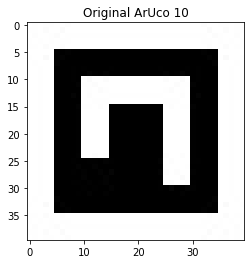

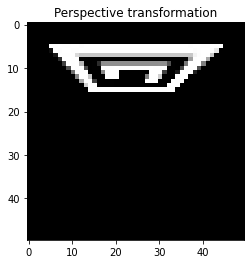

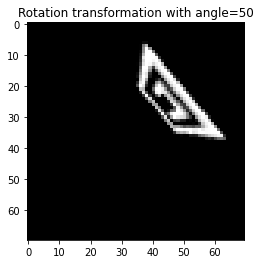

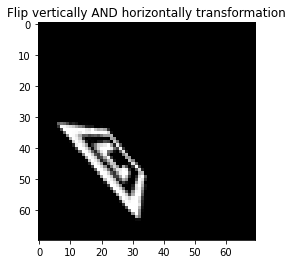

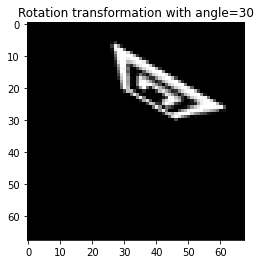

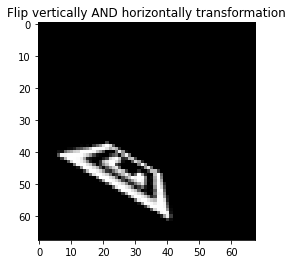

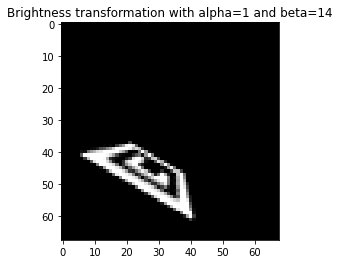

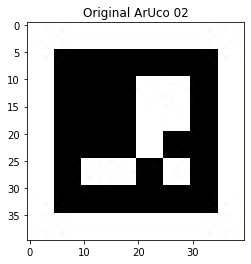

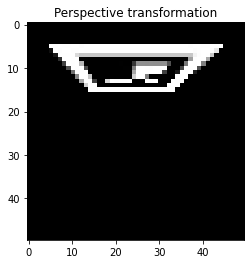

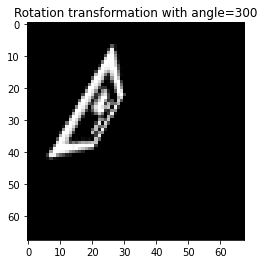

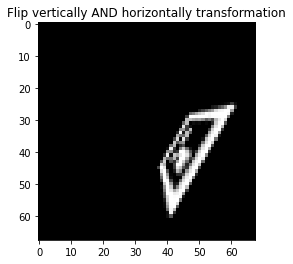

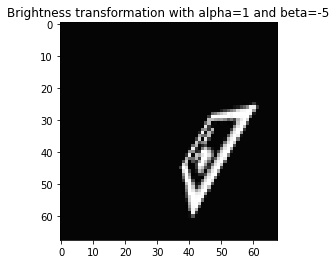

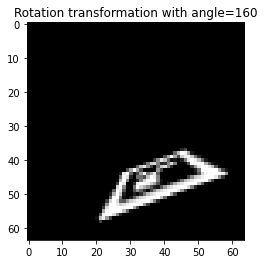

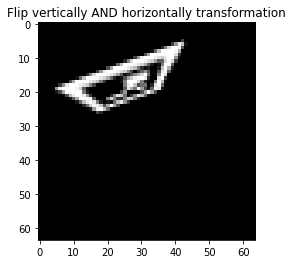

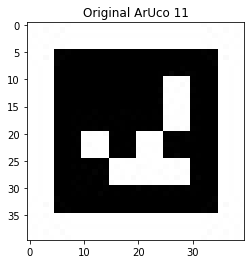

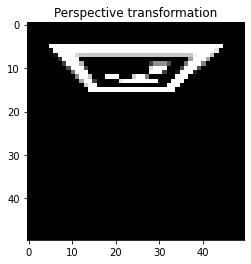

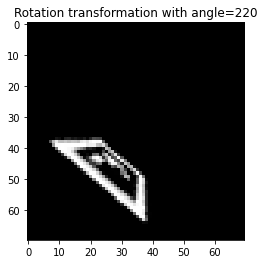

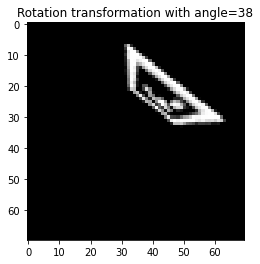

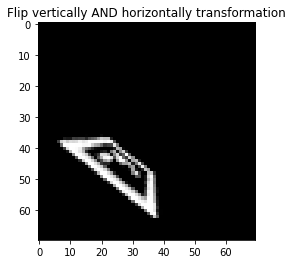

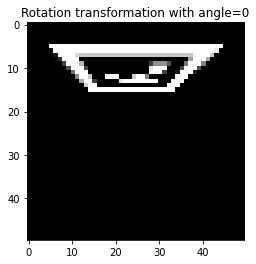

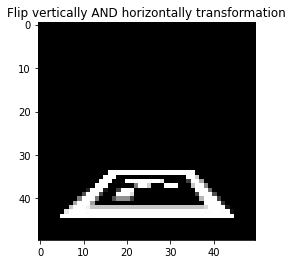

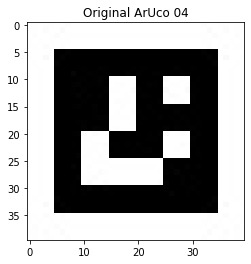

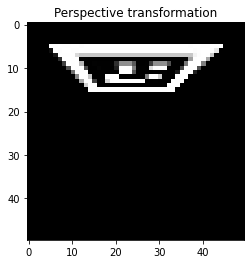

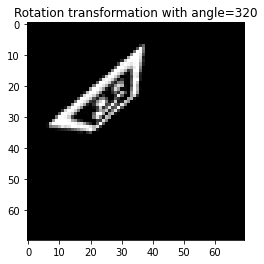

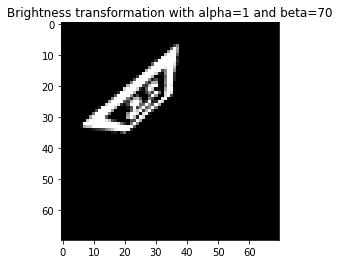

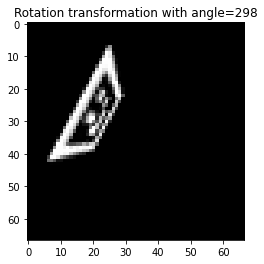

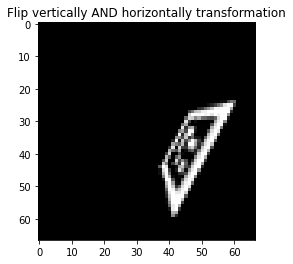

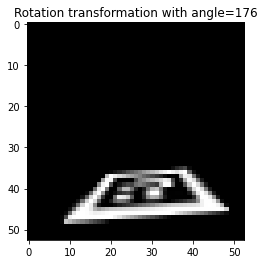

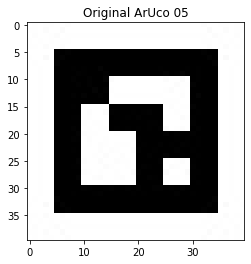

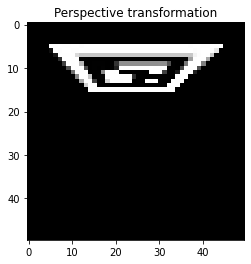

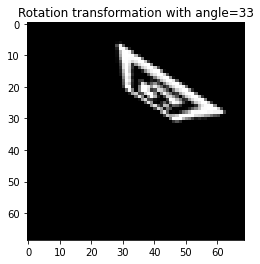

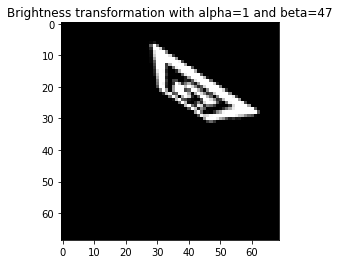

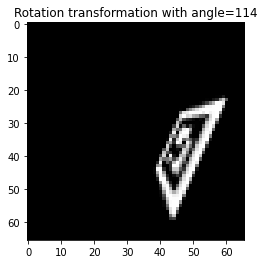

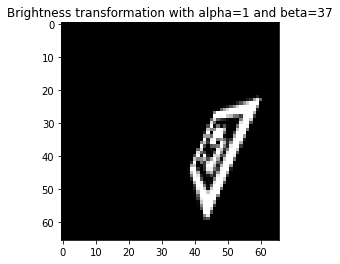

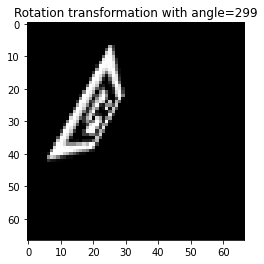

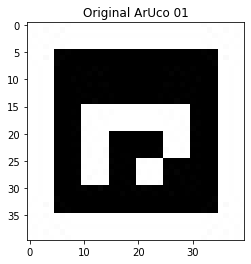

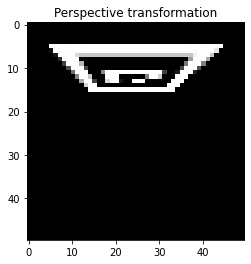

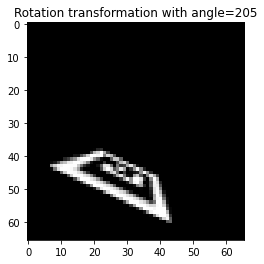

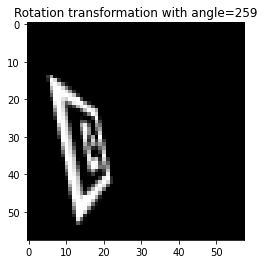

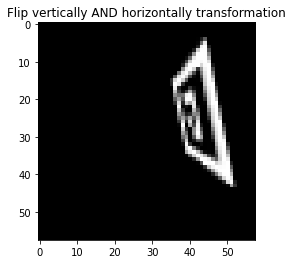

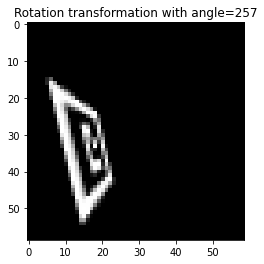

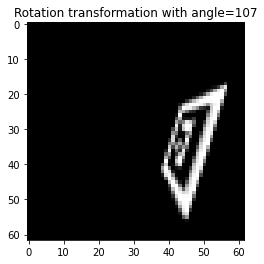

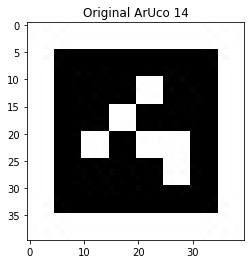

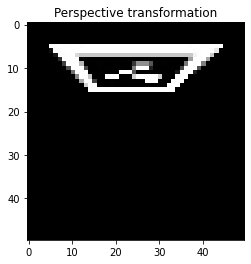

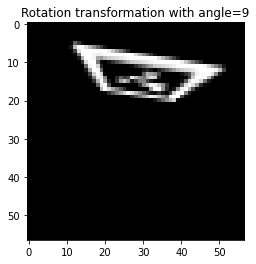

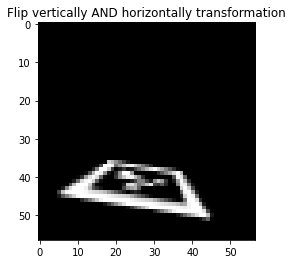

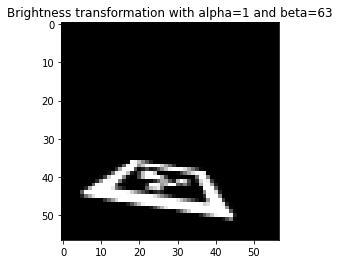

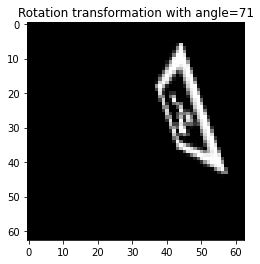

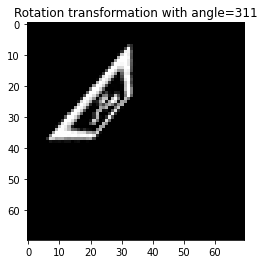

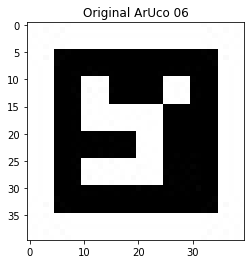

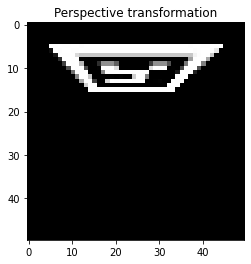

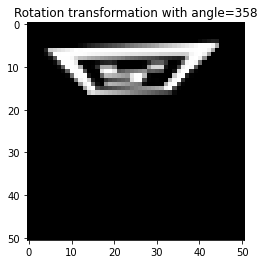

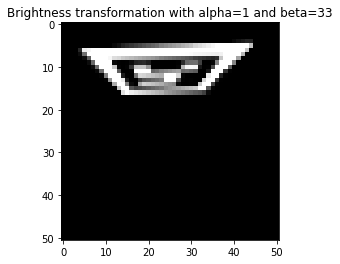

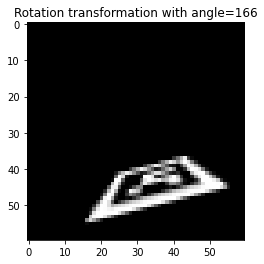

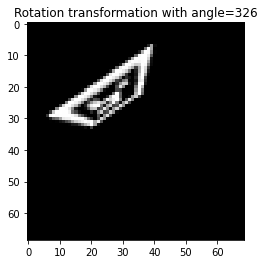

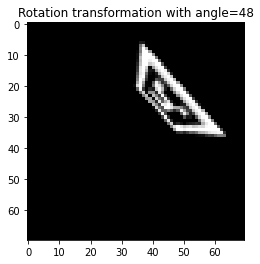

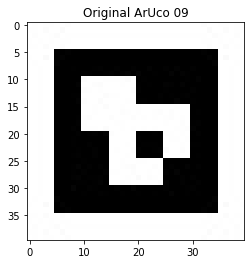

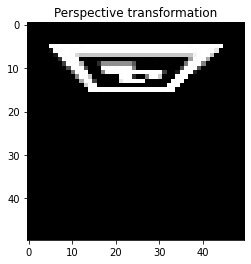

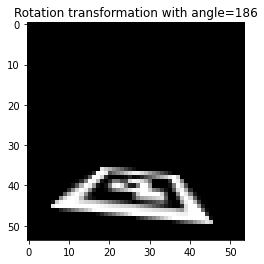

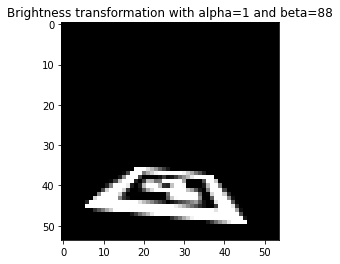

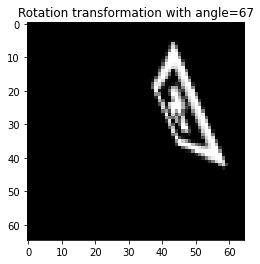

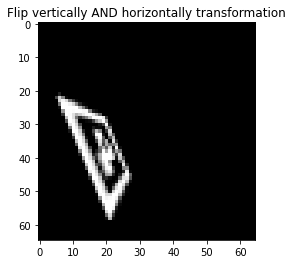

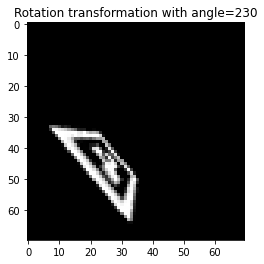

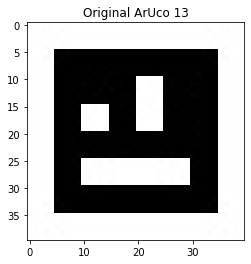

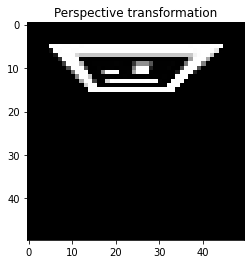

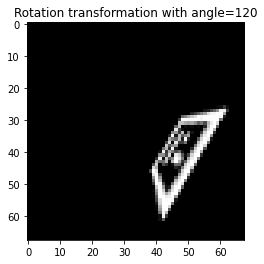

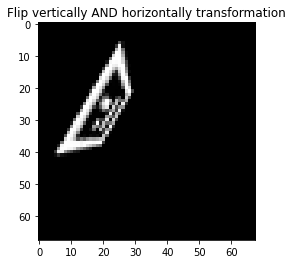

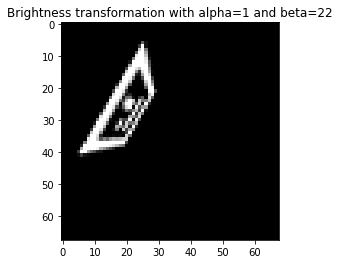

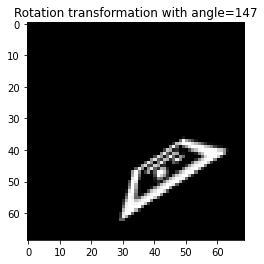

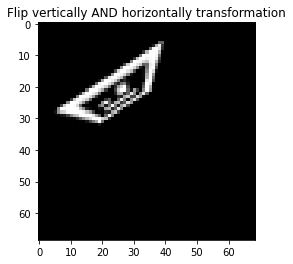

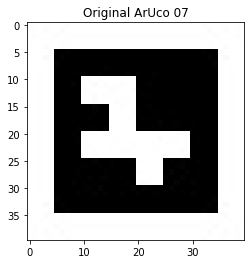

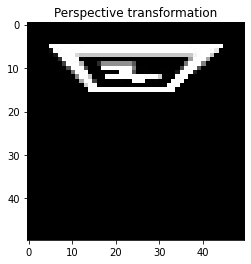

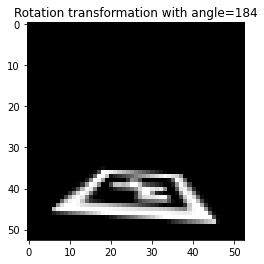

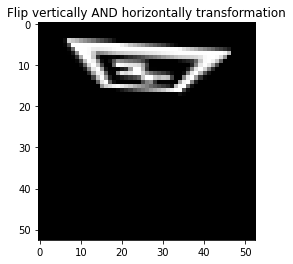

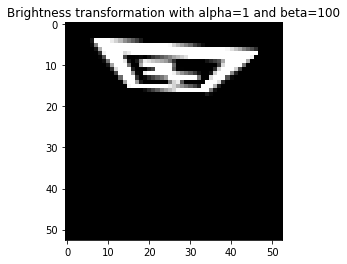

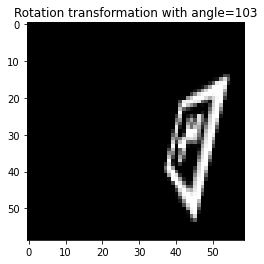

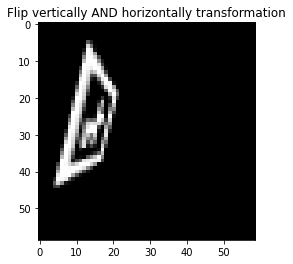

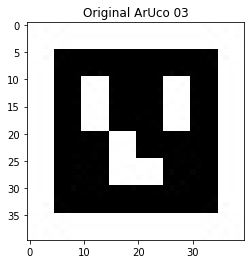

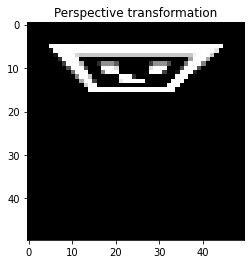

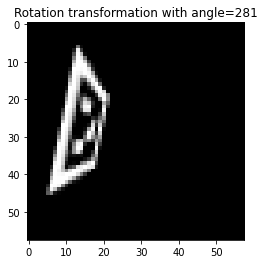

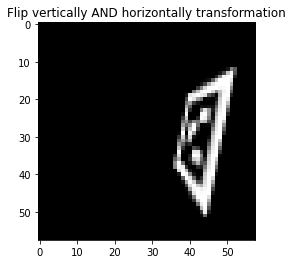

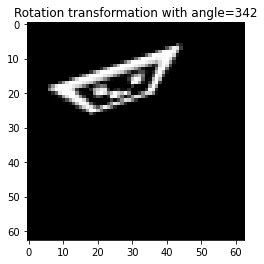

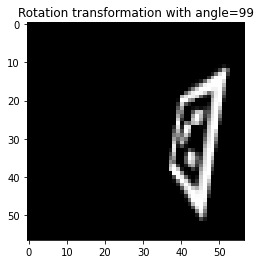

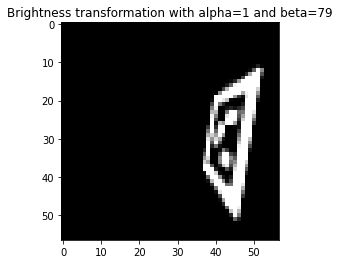

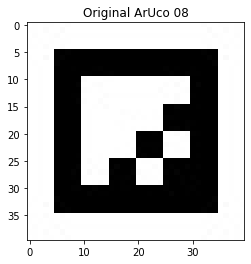

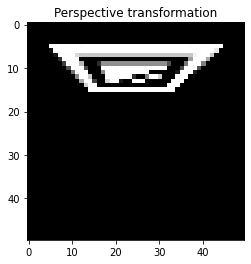

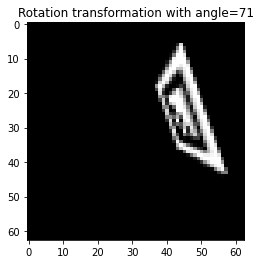

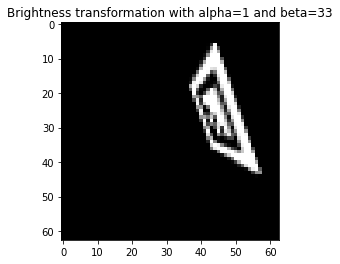

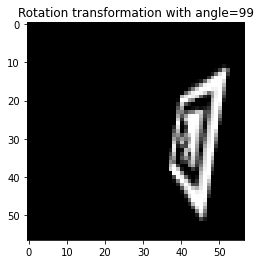

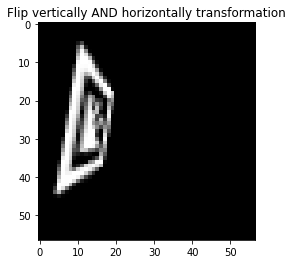

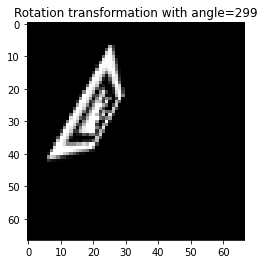

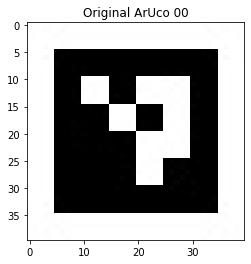

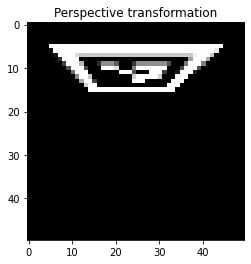

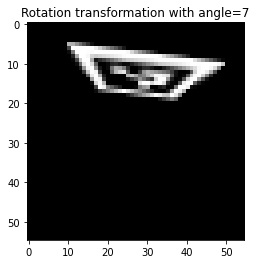

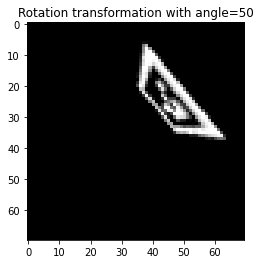

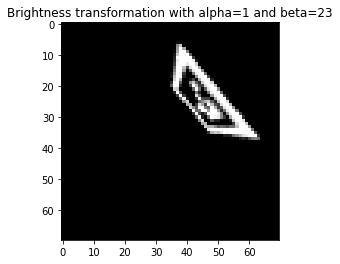

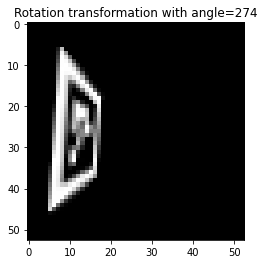

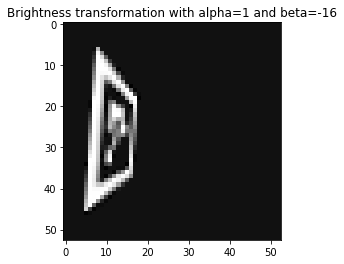

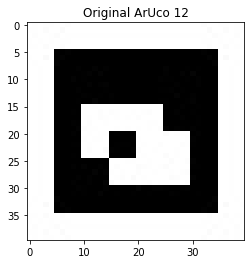

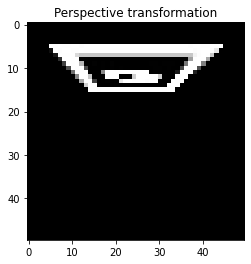

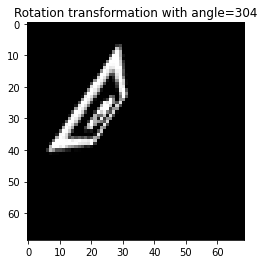

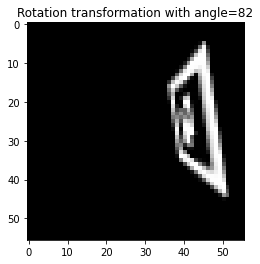

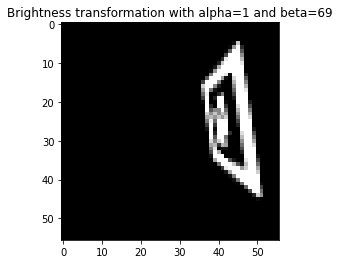

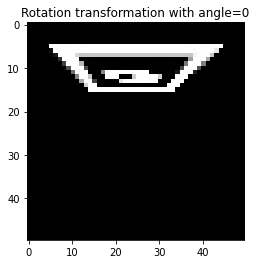

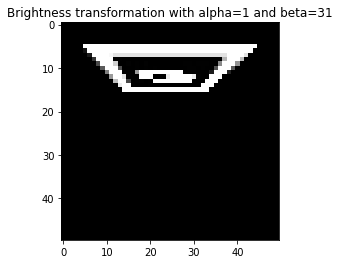

In [ ]:
Path(out_dir).mkdir(parents=True, exist_ok=True)
# read all ArUco filenames
aruco_list = [f for f in os.listdir(name_of_directory) if os.path.isfile(os.path.join(name_of_directory,f))]

# for each ArUco filename
for aruco_name in aruco_list:
  # create the output directory
  # Path(os.path.join(out_dir, aruco_name[:-4])).mkdir(parents=True, exist_ok=True)
  # out_dir_aruco = os.path.join(out_dir, aruco_name[:-4])
  out_dir_aruco = out_dir


  # read the ArUco
  original_aruco = cv2.imread(os.path.join(name_of_directory, aruco_name), cv2.IMREAD_GRAYSCALE)
  original_width, original_height = original_aruco.shape[:2]
  # print the original image
  plt.imshow(original_aruco, cmap='gray')
  plt.title(f'Original ArUco {aruco_name[-6:-4]}')
  plt.show()
  print('\n')

  # perspective transformation
  # edited_aruco = perspective_transf(original_aruco, np.float32([[10,20],[49,20],[39,35],[20,35]]))
  edited_aruco = perspective_transf(original_aruco, reduct_fact_width, reduct_fact_height)

  # print transformed image
  plt.title(f'Perspective transformation')
  plt.imshow(edited_aruco, cmap='gray')
  plt.show()
  print('\n')
  # save the edited ArUco
  cv2.imwrite(os.path.join(out_dir_aruco, aruco_name[:-4] + '_00.jpg'), edited_aruco)

  make_transf(edited_aruco, aruco_name, nr_of_transf, 1)



# Download COCO dataset

In [ ]:
#@title Download COCO dataset PARAMETERS
images_dir_name = PARAMS['COCO_DATASET']['imgs_dir_name']
# ann_dir_name = PARAMS['COCO_DATASET']['ann_dir_name']

### Download the COCO dataset images

In [ ]:
!wget http://images.cocodataset.org/zips/train2017.zip
!wget http://images.cocodataset.org/zips/val2017.zip
# !wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

--2021-06-23 09:08:33--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.138.203
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.138.203|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  65.5MB/s    in 7m 38s  

2021-06-23 09:16:11 (40.3 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]

--2021-06-23 09:16:11--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.165.35
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.165.35|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M   115MB/s    in 8.2s    

2021-06-23 09:16:20 (94.7 MB/s) - 

### Unzip downloaded zip files and remove them

In [ ]:
path = os.path.join('/content', images_dir_name)
Path(path).mkdir(parents=True, exist_ok=True)
# path2 = os.path.join('/content', ann_dir_name)
# Path(path2).mkdir(parents=True, exist_ok=True)

!unzip /content/train2017.zip -d "$path"
!unzip /content/val2017.zip -d "$path"
# !unzip /content/annotations_trainval2017.zip -d "$path2"

!rm /content/train2017.zip
!rm /content/val2017.zip
# !rm /content/annotations_trainval2017.zip

Streaming output truncated to the last 5000 lines.
 extracting: /content/coco/images/val2017/000000212226.jpg  
 extracting: /content/coco/images/val2017/000000231527.jpg  
 extracting: /content/coco/images/val2017/000000578922.jpg  
 extracting: /content/coco/images/val2017/000000062808.jpg  
 extracting: /content/coco/images/val2017/000000119038.jpg  
 extracting: /content/coco/images/val2017/000000114871.jpg  
 extracting: /content/coco/images/val2017/000000463918.jpg  
 extracting: /content/coco/images/val2017/000000365745.jpg  
 extracting: /content/coco/images/val2017/000000320425.jpg  
 extracting: /content/coco/images/val2017/000000481404.jpg  
 extracting: /content/coco/images/val2017/000000314294.jpg  
 extracting: /content/coco/images/val2017/000000335328.jpg  
 extracting: /content/coco/images/val2017/000000513688.jpg  
 extracting: /content/coco/images/val2017/000000158548.jpg  
 extracting: /content/coco/images/val2017/000000132116.jpg  
 extracting: /content/coco/images/

# All ArUco Overlay

In [ ]:
#@title Overlay PARAMETERS
dataset_path = PARAMS['IMAGE_OVERLAY']['dataset_path']
labels_path = PARAMS['IMAGE_OVERLAY']['labels_path']
imgs_path = PARAMS['IMAGE_OVERLAY']['imgs_path']
canny_thld1 = PARAMS['IMAGE_OVERLAY']['canny_threshold1'] # first threshold for the hysteresis procedure
canny_thld2 = PARAMS['IMAGE_OVERLAY']['canny_threshold2'] # second threshold for the hysteresis procedure
images_dir_name = PARAMS['COCO_DATASET']['imgs_dir_name']
nr_of_imgs_for_aruco = PARAMS['IMAGE_OVERLAY']['nr_of_imgs_for_aruco']
imgs_width_range = PARAMS['IMAGE_OVERLAY']['range_images_size_width']
imgs_height_range = PARAMS['IMAGE_OVERLAY']['range_images_size_height']

In [ ]:
# create the output directories
out_dir_imgs = os.path.join('/content', dataset_path, imgs_path)
Path(out_dir_imgs).mkdir(parents=True, exist_ok=True)

out_dir = os.path.join('/content', dataset_path, labels_path)
Path(out_dir).mkdir(parents=True, exist_ok=True)

In [ ]:
def write_label(min_x, min_y, max_x, max_y, img_filename, img, x, y, aruco_filename):

  # find center point, width and height of the bounding box
  x_center = (min_x + (max_x - min_x) / 2) + x
  y_center = (min_y + (max_y - min_y) / 2) + y
  width_BB = (max_x - min_x)
  height_BB = (max_y - min_y)

  # normalize box coordinates and center point
  x_center = x_center / img.shape[1]
  y_center = y_center / img.shape[0]
  width_BB = width_BB / img.shape[1]
  height_BB = height_BB / img.shape[0]

  # extract filename from the ArUco path
  aruco_filename = os.path.basename(aruco_filename)
  aruco_filename = os.path.splitext(aruco_filename)[0]

  # extract filename from the image path
  img_filename = os.path.basename(img_filename)
  img_filename = os.path.splitext(img_filename)[0]
  
  # save the label file
  with open(os.path.join(out_dir, img_filename + '.txt'), 'w') as f:
    f.write(f'{aruco_filename[-5:-3]} {x_center} {y_center} {width_BB} {height_BB}')

In [ ]:
def overlay_image_alpha(img, img_overlay, x, y, alpha_mask, img_filename, aruco_filename):
    """Overlay `img_overlay` onto `img` at (x, y) and blend using `alpha_mask`.

    `alpha_mask` must have same HxW as `img_overlay` and values in range [0, 1].
    """
    # Image ranges
    y1, y2 = max(0, y), min(img.shape[0], y + img_overlay.shape[0])
    x1, x2 = max(0, x), min(img.shape[1], x + img_overlay.shape[1])

    # Overlay ranges
    y1o, y2o = max(0, -y), min(img_overlay.shape[0], img.shape[0] - y)
    x1o, x2o = max(0, -x), min(img_overlay.shape[1], img.shape[1] - x)

    # Exit if nothing to do
    if y1 >= y2 or x1 >= x2 or y1o >= y2o or x1o >= x2o:
        return

    # Blend overlay within the determined ranges
    img_crop = img[y1:y2, x1:x2]
    img_overlay_crop = img_overlay[y1o:y2o, x1o:x2o]
    alpha = alpha_mask[y1o:y2o, x1o:x2o, np.newaxis]
    np.set_printoptions(threshold=np.inf)
    alpha_inv = 1.0 - alpha
    # get the white pixels
    indices = np.where(alpha_inv == 0)

    # min x
    x_min = np.amin(indices[1])
    # min y
    y_min = np.amin(indices[0])

    # max x
    x_max = np.amax(indices[1])
    # max y
    y_max = np.amax(indices[0])

    # write the label
    write_label(x_min, y_min, x_max, y_max, img_filename, img, x, y, aruco_filename)

    img_crop[:] = alpha * img_overlay_crop + alpha_inv * img_crop

    # cv2.rectangle(img_crop,(x_min,y_min),(x_max,y_max),(0,255,0),1)

In [ ]:
def overlay(img_overlay_rgba, img, img_filename, aruco_filename):
  
  # ArUco width and height
  img_width, img_height = img_overlay_rgba.shape[:2]
  
  # overlay point (x, y)
  x, y = random.randint(0, img.shape[1] - img_width), random.randint(0, img.shape[0] - img_height)

  # crop the original image
  img_overlay_rgba = np.repeat(img_overlay_rgba.reshape((img_width, img_height, 1)), 4, axis=2)

  # Perform blending
  # alpha_mask = img_overlay_rgba[:, :, 1] / 255.0
  # cv2_imshow(alpha_mask)
  # img_result = img[:, :, :3].copy()
  # img_overlay = img_overlay_rgba[:, :, :3]
  # overlay_image_alpha(img_result, img_overlay, x, y, alpha_mask)

  # find edges in the ArUco image
  edges = cv2.Canny(img_overlay_rgba, canny_thld1, canny_thld2)
  edges = cv2.dilate(edges, None)
  edges = cv2.erode(edges, None)

  #-- Find contours in edges, sort by area ---------------------------------------------
  contour_info = []
  contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

  for c in contours:
      contour_info.append((
          c,
          cv2.isContourConvex(c),
          cv2.contourArea(c),
      ))
  contour_info = sorted(contour_info, key=lambda c: c[2], reverse=True)

  # create an empty mask
  mask = np.zeros(edges.shape)

  # draw filled polygon on it corresponding to largest contour (mask is black, polygon is white)
  for c in contour_info:
      cv2.fillConvexPoly(mask, c[0], (255))


  alpha_mask = mask / 255.0
  img_result = img[:, :, :3].copy()
  img_overlay = img_overlay_rgba[:, :, :3]

  overlay_image_alpha(img_result, img_overlay, x, y, alpha_mask, img_filename, aruco_filename)

  # show the result
  # plt.imshow(img_result)
  # plt.show()

  # save the result
  cv2.imwrite(os.path.join(out_dir_imgs, os.path.basename(img_filename)), cv2.cvtColor(img_result, cv2.COLOR_RGB2BGR))

In [ ]:
# read all ArUco filenames from the corresponding folder
name_of_directory = os.path.join(PARAMS['GLOBAL']['aruco_folder'], PARAMS['ARUCO_TRANSF']['out_dir_name'])
aruco_list = [f for f in os.listdir(name_of_directory) if os.path.isfile(os.path.join(name_of_directory,f))]

# read all images filenames from the corresponding folder
name_of_directory_imgs = os.path.join('/content', images_dir_name, 'train2017')
imgs_list = [f for f in os.listdir(name_of_directory_imgs) if os.path.isfile(os.path.join(name_of_directory_imgs,f))]

# # download the sample image
# !wget 'https://www.contentcustoms.com/assets/cms/uploads/images/New%20Images%20(Illustrations)/image-logo-design-services%20300x200.jpg' -O sample.jpg
# # open the image and create a NumPy array
# img = Image.open(os.path.join('/content', 'sample.jpg'))
# img_array = np.array(img)
# print(img_array.shape)

print(len(aruco_list))
print(len(imgs_list))

# for each ArUco filename make the overlay
for aruco_name in aruco_list:
  # read the ArUco image and create a NumPy array
  arucoImg = Image.open(os.path.join(name_of_directory, aruco_name))
  aruco = np.array(arucoImg)
  index = 0
  # print(f'CICLO ESTERNO - {aruco_name}')
  for image in imgs_list:
    # print(f'CICLO INTERNO - {image}')

    # open the image and create a NumPy array
    img = Image.open(os.path.join(name_of_directory_imgs, image))
    img_array = np.array(img)
    img_x, img_y = img_array.shape[:2]

    # remove the image from the images list
    imgs_list.remove(image)
    
    # if image width and height are not in specified range, continue with next image
    if img_x < imgs_width_range[0] or img_x > imgs_width_range[1] or img_y < imgs_height_range[0] or img_y > imgs_height_range[1]:
      continue

    # if the image is grayscale, continue with next image
    if len(img_array.shape)<3:
      continue

    # increment number of processed imgs for current ArUco
    index +=1

    # if the number of processed imgs is greater than specified number, switch to next ArUco
    if index > nr_of_imgs_for_aruco:
      break

    # make the overlay
    overlay(aruco, img_array, img.filename, arucoImg.filename)

Streaming output truncated to the last 5000 lines.
97098
NO
97096
NO
97095
NO
97094
NO
97093
NO
97091
NO
97090
NO
97089
NO
97088
NO
97087
NO
97086
NO
97085
NO
97084
NO
97083
NO
97082
NO
97081
NO
97080
NO
97079
NO
97078
NO
97076
NO
97075
NO
97074
NO
97073
NO
97072
NO
97071
NO
97070
NO
97069
NO
97068
NO
97067
NO
97066
NO
97065
NO
97064
NO
97063
NO
97062
NO
97061
NO
97060
NO
97059
NO
97058
NO
97057
NO
97056
NO
97055
NO
97053
NO
97052
NO
97051
NO
97050
NO
97049
NO
97048
NO
97047
NO
97046
NO
97045
NO
97044
NO
97043
NO
97042
NO
97041
NO
97040
NO
97039
NO
97038
NO
97037
NO
97035
NO
97034
NO
97033
NO
97032
NO
97031
NO
97030
NO
97029
NO
97028
NO
97027
NO
97025
NO
97024
NO
97023
NO
97022
NO
97021
NO
97020
NO
97019
NO
97018
NO
97017
NO
97016
NO
97015
NO
97014
NO
97012
NO
97011
NO
97010
NO
97009
NO
97008
NO
97007
NO
97006
NO
97005
NO
97004
NO
97003
NO
97002
NO
97000
NO
96999
NO
96998
NO
96997
NO
96996
NO
96995
NO
96993
NO
96992
NO
96991
NO
96990
NO
96989
NO
96988
NO
96987
NO
96986
NO
96985
NO
9698

# Save the dataset to Google Drive

In [ ]:
# mount Google Drive
drive.mount('/content/drive')

# save to Google Drive
dt = time.strftime("%Y_%m_%d_%H_%M")

src = '/content/dataset/'
dest = '/content/drive/MyDrive/TestColab/%s' % dt

shutil.copytree(src, dest)

Mounted at /content/drive


'/content/drive/MyDrive/TestColab/2021_06_23_09_51'

In [ ]:
# unmount Google Drive
drive.flush_and_unmount()

# Prove

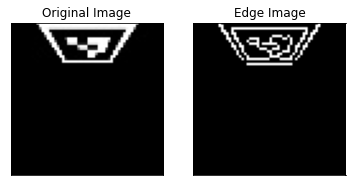

In [ ]:
# imgg = np.array(Image.open(os.path.join(out_dir, 'aruco_00', 'aruco_00_00.jpg')))
# edges = cv2.Canny(imgg,100,200)
# plt.subplot(121),plt.imshow(imgg,cmap = 'gray')
# plt.title('Original Image'), plt.xticks([]), plt.yticks([])
# plt.subplot(122),plt.imshow(edges,cmap = 'gray')
# plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
# plt.show()

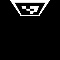

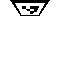

In [ ]:
# imgg = cv2.imread(os.path.join(out_dir, 'aruco_00', 'aruco_00_00.jpg'))
# gray = cv2.cvtColor(imgg, cv2.COLOR_BGR2GRAY)
# cv2_imshow(gray)
# ret,bin = cv2.threshold(gray,127,255,cv2.THRESH_BINARY_INV)
# cv2_imshow(bin)

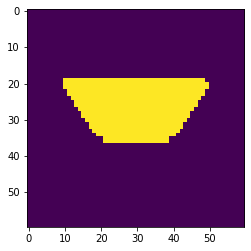

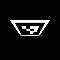

In [ ]:
def remove_background(img):
    #== Parameters =======================================================================
    BLUR = 5
    CANNY_THRESH_1 = 10
    CANNY_THRESH_2 = 100
    MASK_DILATE_ITER = 20
    MASK_ERODE_ITER = 20
    MASK_COLOR = (0.0,0.0,0.0) # In BGR format
    
    #== Processing =======================================================================
    
    #-- Read image -----------------------------------------------------------------------
    img = cv2.imread(img)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    #-- Edge detection -------------------------------------------------------------------
    edges = cv2.Canny(gray, CANNY_THRESH_1, CANNY_THRESH_2)
    edges = cv2.dilate(edges, None)
    edges = cv2.erode(edges, None)
    
    #-- Find contours in edges, sort by area ---------------------------------------------
    contour_info = []
    contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
    
    for c in contours:
        contour_info.append((
            c,
            cv2.isContourConvex(c),
            cv2.contourArea(c),
        ))
    contour_info = sorted(contour_info, key=lambda c: c[2], reverse=True)
    
    
    #-- Create empty mask, draw filled polygon on it corresponding to largest contour ----
    # Mask is black, polygon is white
    mask = np.zeros(edges.shape)
    for c in contour_info:
        cv2.fillConvexPoly(mask, c[0], (255))
    plt.imshow(mask)
    plt.show()
    # cv2.fillConvexPoly(mask, max_contour[0], (255))
    
    #-- Smooth mask, then blur it --------------------------------------------------------
    mask = cv2.dilate(mask, None, iterations=MASK_DILATE_ITER)
    mask = cv2.erode(mask, None, iterations=MASK_ERODE_ITER)
    mask = cv2.GaussianBlur(mask, (BLUR, BLUR), 0)
    mask_stack = np.dstack([mask]*3)    # Create 3-channel alpha mask
    
    #-- Blend masked img into MASK_COLOR background --------------------------------------
    mask_stack  = mask_stack.astype('float32') / 255.0          # Use float matrices, 
    img         = img.astype('float32') / 255.0                 #  for easy blending
    
    masked = (mask_stack * img) + ((1 - mask_stack) * MASK_COLOR) # Blend
    masked = (masked * 255).astype('uint8')                     # Convert back to 8-bit 
    # cv2.imwrite('img.png', masked)
    cv2_imshow(masked)

remove_background(os.path.join(out_dir, 'aruco_00', 'aruco_00_00.jpg'))

## ArUco Transformations in OpenCV

In [ ]:
#@title OpenCV Transformations PARAMETERS
aruco_filename = PARAMS['ARUCO_TRANSF']['aruco_filename']

### Rotazione

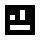

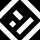

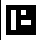

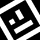

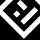

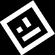

In [ ]:
# load the image and show it
image = cv2.imread(aruco_filename)
cv2_imshow(image)
print('\n')
# grab the dimensions of the image and calculate the center of the image
(h, w) = image.shape[:2]
(cX, cY) = (w // 2, h // 2)
# rotate our image by 45 degrees around the center of the image
M = cv2.getRotationMatrix2D((cX, cY), 45, 1.0)
image_rotated = cv2.warpAffine(image, M, (w, h))
cv2_imshow(image_rotated)
print('\n')
# rotate our image by -90 degrees around the image
M = cv2.getRotationMatrix2D((cX, cY), -90, 1.0)
image_rotated = cv2.warpAffine(image, M, (w, h))
cv2_imshow(image_rotated)
print('\n')
# rotate our image by 30 degrees around the center of the image
M = cv2.getRotationMatrix2D((cX, cY), 30, 1.0)
image_rotated = cv2.warpAffine(image, M, (w, h))
cv2_imshow(image_rotated)
print('\n')
# rotate our image around an arbitrary point rather than the center
M = cv2.getRotationMatrix2D((10, 10), 45, 1.0)
image_rotated = cv2.warpAffine(image, M, (w, h))
cv2_imshow(image_rotated)
print('\n')
# rotate our image by 33 degrees counterclockwise, ensuring the entire rotated image still renders within the viewing area
image_rotated = imutils.rotate_bound(image, -33)
cv2_imshow(image_rotated)
print('\n')

### Flip

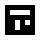

In [ ]:
image = cv2.imread(aruco_filename)

# Nel nostro caso questi due commentati non dovrebbero aver senso e quindi non credo vadano utilizzati

# image_flipvertical= cv2.flip(image, 0)
# cv2_imshow(image_flipvertical)
# print('\n')

# image_fliphorizontal = cv2.flip(image, 1)
# cv2_imshow(image_fliphorizontal)
# print('\n')

image_flip = cv2.flip(image, -1)
cv2_imshow(image_flip)
print('\n')

### Perspective Transformation

#### Altre Funzioni (NON USATE per ora)

In [ ]:
# import the necessary packages
import numpy as np
import cv2

def order_points(pts):
	# initialzie a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype = "float32")
	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
	# now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
	# return the ordered coordinates
	return rect

In [ ]:
def new_size(pts):
  (tl, tr, br, bl) = pts
  # compute the width of the new image, which will be the
	# maximum distance between bottom-right and bottom-left
	# x-coordiates or the top-right and top-left x-coordinates
  widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
  widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
  maxWidth = max(int(widthA), int(widthB))
	# compute the height of the new image, which will be the
	# maximum distance between the top-right and bottom-right
	# y-coordinates or the top-left and bottom-left y-coordinates
  heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
  heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
  maxHeight = max(int(heightA), int(heightB))
  return maxWidth + 1, maxHeight + 1

#### Code (DIMENSIONI: 60x60)

(40, 40)


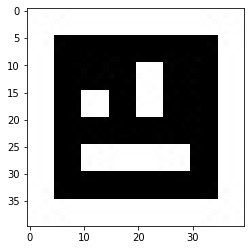

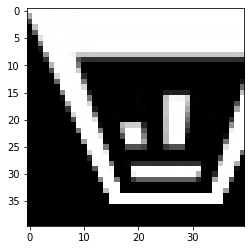

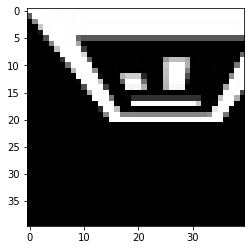

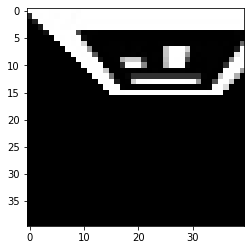

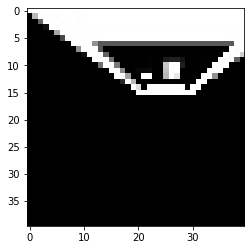

In [ ]:
# read the ArUco
paper = cv2.imread(os.path.join('/content/', aruco_filename), cv2.IMREAD_GRAYSCALE)
# read the ArUco width and height
paper_width = paper.shape[0]
paper_height = paper.shape[1]
print(paper.shape)

# set the coordinates that we want to perspective transform (the coords of the whole image)
pts1 = np.float32([[0,0], [paper_width - 1 ,0], [paper_height - 1,paper_width - 1], [0, paper_height - 1]])
# print(pts1)
# pts1 = order_points(pts1)
# print(pts1)

# set some sizes of the transformed image
pts_array = []
pts_array.append(np.float32([[0,0],[49,0],[35,35],[15,35]]))
pts_array.append(np.float32([[0,0],[49,0],[35,20],[15,20]]))
pts_array.append(np.float32([[0,0],[49,0],[35,15],[15,15]]))
pts_array.append(np.float32([[0,0],[49,0],[30,15],[20,15]]))

# mark the corners of the image
# for val in pts1:
#   cv2.circle(paper,tuple(val.astype(np.int)),2,(0,0,255),-1)

# print the original image
plt.imshow(paper, cmap='gray')
plt.show()

# for each defined size transform the original image 
for pts2 in pts_array:
  # print(pts2)
  # pts2 = order_points(pts2)
  # print(pts2)
  # new_width, new_height = new_size(pts2)

  # set the size of the result image 
  new_width, new_height = paper_width, paper_height
  # transformation matrix
  M = cv2.getPerspectiveTransform(pts1, pts2)
  # transform the original image
  dst = cv2.warpPerspective(paper, M, (new_width, new_height))
  # print transformed image
  print('\n')
  plt.imshow(dst, cmap='gray')
  plt.show()

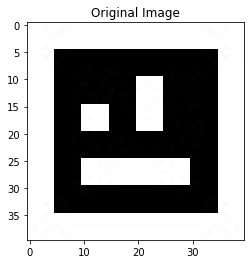

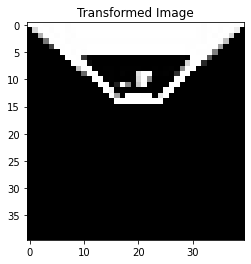

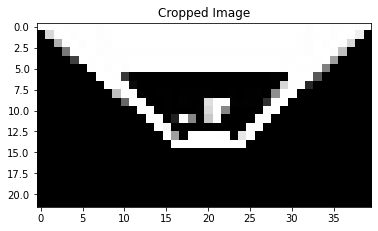

In [ ]:
#@title Transformation Parameters { run: "auto" }
height_reduction_pct = 65 #@param {type:"slider", min:0, max:100, step:5}
width_reduction_pct = 40 #@param {type:"slider", min:0, max:50, step:5}

paper = cv2.imread('./aruco/aruco_13.jpg', cv2.IMREAD_GRAYSCALE)
paper_width = paper.shape[0]
paper_height = paper.shape[1]
new_width, new_height = paper_width, paper_height 

# Coordinates that you want to Perspective Transform (the coords of the whole image)
pts1 = np.float32([[0,0], [paper_width - 1 ,0], [paper_height - 1,paper_width - 1], [0, paper_height - 1]])

# Size of the Transformed Image
br = [paper_width - ((paper_width*width_reduction_pct)/100), paper_height - ((paper_height*height_reduction_pct)/100)]
bl = [((paper_width*width_reduction_pct)/100), paper_height - ((paper_height*height_reduction_pct)/100)]
pts2 = np.float32([[0,0], [paper_width - 1 ,0], br, bl])

plt.imshow(paper, cmap='gray')
plt.title('Original Image')
plt.show()

# transformation matrix
M = cv2.getPerspectiveTransform(pts1, pts2)
dst = cv2.warpPerspective(paper, M, (new_width, paper_height))
  
print('\n')
plt.imshow(dst, cmap='gray')
plt.title('Transformed Image')
plt.show()

print('\n')
x1, y1 =0, 0
x2, y2 =60, 22
image_cropped= dst[y1:y2, x1:x2]
plt.imshow(image_cropped, cmap='gray')
plt.title('Cropped Image')
plt.show()


### Blur

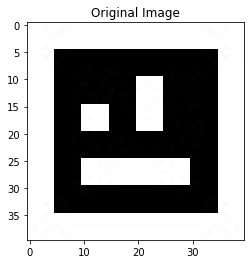

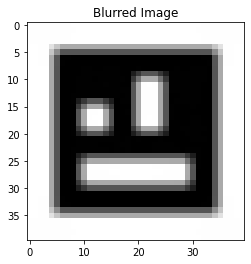

In [ ]:
# read image
image = cv2.imread(os.path.join('/content/', aruco_filename), cv2.IMREAD_GRAYSCALE)

image_blurred = cv2.blur(image, (3,3))

# print original image
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.show()

print('\n')

# print blurred image
plt.imshow(image_blurred, cmap='gray')
plt.title('Blurred Image')
plt.show()

## Overlay ArUco - Image

In [ ]:
#@title Overlay: ArUco to Image
sample_aruco_filename = PARAMS['IMAGE_OVERLAY']['aruco_filename']
sample_image_filename = PARAMS['IMAGE_OVERLAY']['image_filename']

In [ ]:
def overlay_image_alpha(img, img_overlay, x, y, alpha_mask):
    """Overlay `img_overlay` onto `img` at (x, y) and blend using `alpha_mask`.

    `alpha_mask` must have same HxW as `img_overlay` and values in range [0, 1].
    """
    # Image ranges
    y1, y2 = max(0, y), min(img.shape[0], y + img_overlay.shape[0])
    x1, x2 = max(0, x), min(img.shape[1], x + img_overlay.shape[1])

    # Overlay ranges
    y1o, y2o = max(0, -y), min(img_overlay.shape[0], img.shape[0] - y)
    x1o, x2o = max(0, -x), min(img_overlay.shape[1], img.shape[1] - x)

    # Exit if nothing to do
    if y1 >= y2 or x1 >= x2 or y1o >= y2o or x1o >= x2o:
        return

    # Blend overlay within the determined ranges
    img_crop = img[y1:y2, x1:x2]
    img_overlay_crop = img_overlay[y1o:y2o, x1o:x2o]
    alpha = alpha_mask[y1o:y2o, x1o:x2o, np.newaxis]
    # img_crop[:] = alpha * img_overlay_crop

    # cv2_imshow(img_crop)
    # cv2_imshow(img_overlay_crop)
    alpha_inv = 1.0 - alpha

    img_crop[:] = alpha * img_overlay_crop + alpha_inv * img_crop
    img_crop[:] = alpha * img_overlay_crop

    # cv2_imshow(img_crop)


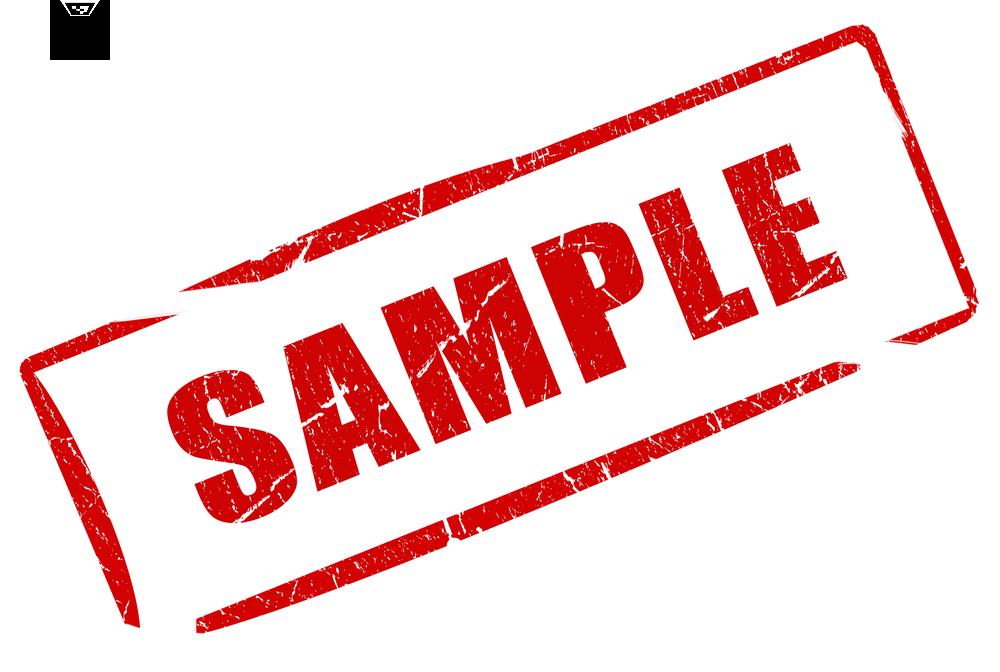

In [ ]:
# prepare inputs
x, y = 50, 0
img = np.array(Image.open(os.path.join('/content', sample_image_filename)))
img_overlay_rgba = np.array(Image.open(os.path.join('/content', sample_aruco_filename)))

# print(img_overlay_rgba.shape)
img_overlay_rgba = np.repeat(img_overlay_rgba.reshape((50, 50, 1)), 4, axis=2)
# print(img_overlay_rgba.shape)

# perform blending
alpha_mask = img_overlay_rgba[:, :, 3] / 255.0
img_result = img[:, :, :3].copy()
img_overlay = img_overlay_rgba[:, :, :3]
overlay_image_alpha(img_result, img_overlay, x, y, alpha_mask)

# save result
img_result = Image.fromarray(img_result, 'RGB')
img_result.save("img_result.jpg")
# img_result.show()

# load saved image 
open_cv_image = np.array(img_result) 
# Convert RGB to BGR 
open_cv_image = open_cv_image[:, :, ::-1].copy() 
# print saved image
cv2_imshow(open_cv_image)